# Task 2: Implementation and Training

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
torch.autograd.set_detect_anomaly(True)
torch.manual_seed(41)
from data_generation import Poisson_data_generator

## Define the MLP

In [3]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, n_hidden_layers, width):
        super(MLP, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.n_hidden_layers = n_hidden_layers
        self.width = width

        self.activation = nn.Tanh()

        self.input_layer = nn.Linear(self.input_dim, self.width)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.width, self.width) for _ in range(self.n_hidden_layers - 1)])
        self.output_layer = nn.Linear(self.width, self.output_dim)
        
        # Xavier initialization for better convergence
        self.init_weights()
    
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.activation(x)
        for l in self.hidden_layers:
            x = l(x)
            x = self.activation(x)
        return self.output_layer(x)

## Define data driven model

In [4]:
class Data_driven_approximator(MLP):
    def __init__(self, n_hidden_layers, width):
        super(Data_driven_approximator, self).__init__(2, 1, n_hidden_layers, width)

    def fit(self, training_set, num_epochs, optimizer, verbose=True):
        history = list()

        for epoch in range(num_epochs):
            if verbose: print("################################ ", epoch, " ################################")

            for input_coords, u_train in training_set:
                def closure():
                    optimizer.zero_grad()
                    u_pred = self(input_coords)
                    loss = torch.mean((u_pred.reshape(-1, ) - u_train.reshape(-1, )) ** 2) 
                    loss.backward()
                    history.append(loss.item())
                    return loss

                optimizer.step(closure=closure)
        
            if verbose and epoch % 50 == 0:
                print(f'Epoch {epoch}, Loss: {history[-1]:.6e}')

        print(f'Final Loss: {history[-1]:.6e}')

        return history


## Define PINN

In [5]:
class PINN(MLP):

    def __init__(self, n_hidden_layers, width, N, device, mesh = "grid", lambda_u=1.0):
        super(PINN, self).__init__(2, 1, n_hidden_layers, width)
        self.device = device
        self.to(self.device)
        self.lambda_u = lambda_u

        self.domain_bounds = ([0.0, 1.0], [0.0, 1.0]) # (x_min, x_max), (y_min, y_max)
        self.space_dimension = 2

        self.mesh = mesh
        self.N = N
        # Number of boundary points per side
        self.num_boundary_points = self.N
        # Number of interior points
        self.num_interior_points = (self.N-1)**2

        # Generator of Sobol sequences
        self.soboleng = torch.quasirandom.SobolEngine(dimension=self.space_dimension)
        
        self.training_set_b, self.training_set_int = self.assemble_datasets()


    def add_boundary_points(self):
        if self.mesh == "grid":
            x_b = torch.linspace(self.domain_bounds[0][0], self.domain_bounds[0][1], self.N, device=self.device)
            y_b = torch.linspace(self.domain_bounds[1][0], self.domain_bounds[1][1], self.N, device=self.device)
            zero = torch.zeros_like(x_b)
            one = torch.ones_like(x_b)

            # assemble the fours sides of the boundary
            lower_side = torch.stack([x_b, zero], dim=1)
            upper_side = torch.stack([x_b, one], dim=1)
            left_side = torch.stack([zero, y_b], dim=1)
            right_side = torch.stack([one, y_b], dim=1)
            # Create boundary points
            boundary_points = torch.cat([lower_side, upper_side, left_side, right_side], dim=0)
            return boundary_points, torch.zeros((boundary_points.shape[0], 1), device=self.device)
        if self.mesh == "random":
            
            # Create random boundary points
            x_b = self.soboleng.draw(self.num_boundary_points, 1).to(self.device) * (self.domain_bounds[0][1] - self.domain_bounds[0][0]) + self.domain_bounds[0][0]
            y_b = self.soboleng.draw(self.num_boundary_points, 1).to(self.device) * (self.domain_bounds[1][1] - self.domain_bounds[1][0]) + self.domain_bounds[1][0]
            zero = torch.zeros_like(x_b)
            one = torch.ones_like(x_b)

            # assemble the fours sides of the boundary
            lower_side = torch.stack([x_b, zero], dim=1)
            upper_side = torch.stack([x_b, one], dim=1)
            left_side = torch.stack([zero, y_b], dim=1)
            right_side = torch.stack([one, y_b], dim=1)
            # Create boundary points
            boundary_points = torch.cat([lower_side, upper_side, left_side, right_side], dim=0)
            return boundary_points, torch.zeros((boundary_points.shape[0], 1), device=self.device)
    
    def add_interior_points(self):
        if self.mesh == "grid":
            # Create a grid of interior points
            x = torch.linspace(self.domain_bounds[0][0], self.domain_bounds[0][1], self.N, device=self.device)
            y = torch.linspace(self.domain_bounds[1][0], self.domain_bounds[1][1], self.N, device=self.device)
            # Remove boundary points
            x = x[1:-1]
            y = y[1:-1]
            # Create a grid of interior points without boundary points
            X, Y = torch.meshgrid(x, y, indexing='ij')
            # reshape to a list of points
            X_interior = X.reshape(-1, 1)
            Y_interior = Y.reshape(-1, 1)
            interior_points = torch.cat([X_interior, Y_interior], dim=1)
            return interior_points, torch.zeros((interior_points.shape[0], 1), device=self.device)
        
        if self.mesh == "random":
            # Create random interior points
            X_interior = self.soboleng.draw(self.num_interior_points, 1).to(self.device) * (self.domain_bounds[0][1] - self.domain_bounds[0][0]) + self.domain_bounds[0][0]
            Y_interior = self.soboleng.draw(self.num_interior_points, 1).to(self.device) * (self.domain_bounds[1][1] - self.domain_bounds[1][0]) + self.domain_bounds[1][0]
            # create a list of interior points
            interior_points = torch.cat([X_interior, Y_interior], dim=1)
            return interior_points, torch.zeros((interior_points.shape[0], 1), device=self.device)
       
    
    def assemble_datasets(self):
        input_b, output_b = self.add_boundary_points()  # S_tb
        input_int, output_int = self.add_interior_points()         # S_int

        training_set_b = DataLoader(torch.utils.data.TensorDataset(input_b, output_b), batch_size=input_b.shape[0], shuffle=False)
        training_set_int = DataLoader(torch.utils.data.TensorDataset(input_int, output_int), batch_size=input_int.shape[0], shuffle=False)

        return training_set_b, training_set_int
    
    def apply_boundary_conditions(self, input_b):
        u_pred_b = self(input_b)
        return u_pred_b
    
    def compute_pde_residual(self, input_int, forcing_term):
        input_int.requires_grad = True
        u = self(input_int)

        grad_u = torch.autograd.grad(u.sum(), input_int, create_graph=True)[0]
        # compute first derivative w.r.t x
        grad_u_x = grad_u[:, 0]
        # compute first derivative w.r.t y
        grad_u_y = grad_u[:, 1]
        # compute second derivative w.r.t x
        grad_u_xx = torch.autograd.grad(
            grad_u_x.sum(), input_int, create_graph=True)[0][:, 0]
        # compute second derivative w.r.t y
        grad_u_yy = torch.autograd.grad(
            grad_u_y.sum(), input_int, create_graph=True)[0][:, 1]
        
        laplacian_u = grad_u_xx + grad_u_yy

        residual =  - laplacian_u - forcing_term(input_int)

        return residual 
    
    def compute_loss(self, inp_train_b, u_train_b, inp_train_int, forcing_term):
        # Boundary loss
        u_pred_b = self.apply_boundary_conditions(inp_train_b)
        
        r_b = u_pred_b.reshape(-1, ) - u_train_b.reshape(-1, )
        r_int = self.compute_pde_residual(inp_train_int, forcing_term)

        loss_b = torch.mean(r_b ** 2)
        loss_int = torch.mean(r_int ** 2)

        # Total loss (removed log10 for better gradients)
        total_loss = loss_b + self.lambda_u * loss_int

        return total_loss
        
    def fit(self, num_epochs, optimizer, forcing_term, verbose=True):
        history = list()

        # Loop over epochs
        for epoch in range(num_epochs):
            if verbose: print("################################ ", epoch, " ################################")

            for j, ((inp_train_b, u_train_b),(inp_train_int, u_train_int)) in enumerate(zip(self.training_set_b, self.training_set_int)):
                def closure():
                    optimizer.zero_grad()
                    loss = self.compute_loss(inp_train_b, u_train_b, inp_train_int, forcing_term)
                    loss.backward()

                    history.append(loss.item())
                    return loss

                optimizer.step(closure=closure)

            if verbose and epoch % 5 == 0:
                print(f'Epoch {epoch}, Loss: {history[-1]:.6e}')

        print(f'Final Loss: {history[-1]:.6e}')

        return history

## Solve Poisson Equation

### Instantiate Models

In [6]:
# Reduced N for faster training - 64 gives 3969 interior points vs 65025
N = 64  
n_hidden_layers = 4
width = 50  # Increased network capacity

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# lambda_u balances boundary vs interior loss
pinn = PINN(n_hidden_layers, width, N, device=device, mesh="grid", lambda_u=1.0)
data_driven_model = Data_driven_approximator(n_hidden_layers, width).to(device)

Using device: cpu


### Generate training data and declaring forcing term

In [7]:
# generate training data for data-driven model
K = 4
data_generator = Poisson_data_generator(N, K)
force, sol = data_generator.generate()

## Train PINN

In [ ]:
# obtain forcing term as a callable function
def forcing_term(x):
    # 1. Detach gradients and convert to numpy
    x_np = x[:, 0].detach().cpu().numpy()
    y_np = x[:, 1].detach().cpu().numpy()
    
    # 2. Compute using the numpy-based generator
    f_np = data_generator.forcing_term(x_np, y_np)
    
    # 3. Convert back to tensor and match device
    return torch.tensor(f_np, dtype=torch.float32, device=x.device).reshape(-1, )   

### Declare oprimizers

In [ ]:
n_epochs_PINN = 2000 
fine_tune_epochs_PINN = 10 
optimizer_LBFGS_PINN = optim.LBFGS(pinn.parameters(),
                              lr=float(0.5),
                              max_iter=50,
                              max_eval=5000,
                              history_size=150,
                              line_search_fn="strong_wolfe",
                              tolerance_change=1.0 * np.finfo(float).eps)
optimizer_ADAM_PINN = optim.Adam(pinn.parameters(),
                            lr=float(0.001))

### Train PINN

In [ ]:
# pre-training with Adam
hist_pre = pinn.fit(num_epochs=n_epochs_PINN,
                optimizer=optimizer_ADAM_PINN,
                forcing_term=forcing_term,
                verbose=True)

In [ ]:
# Fine-tune with LBFGS
hist_fine = pinn.fit(num_epochs=fine_tune_epochs_PINN,
                optimizer=optimizer_LBFGS_PINN,
                forcing_term=forcing_term,
                verbose=True)

hist = hist_pre + hist_fine
plt.figure(dpi=150)
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1, len(hist) + 1), hist, label="Train Loss")
plt.xscale("log")
plt.legend()

#### PINN relative $L^2$ error and plot visualization

In [9]:
x = np.linspace(0, 1, N)
y = np.linspace(0, 1, N)
X, Y = np.meshgrid(x, y, indexing='ij')
U_pred = pinn(torch.tensor(np.stack([X.flatten(), Y.flatten()], axis=1), dtype=torch.float32, device=pinn.device)).detach().cpu().numpy().reshape(N, N)
U_exact = data_generator.exact_solution(X, Y)

err = (torch.mean((torch.tensor(U_pred) - torch.tensor(U_exact)) ** 2) / torch.mean(torch.tensor(U_exact) ** 2)) ** 0.5 * 100
print("L2 Relative Error Norm: ", err.item(), "%")

L2 Relative Error Norm:  781.0209466102364 %


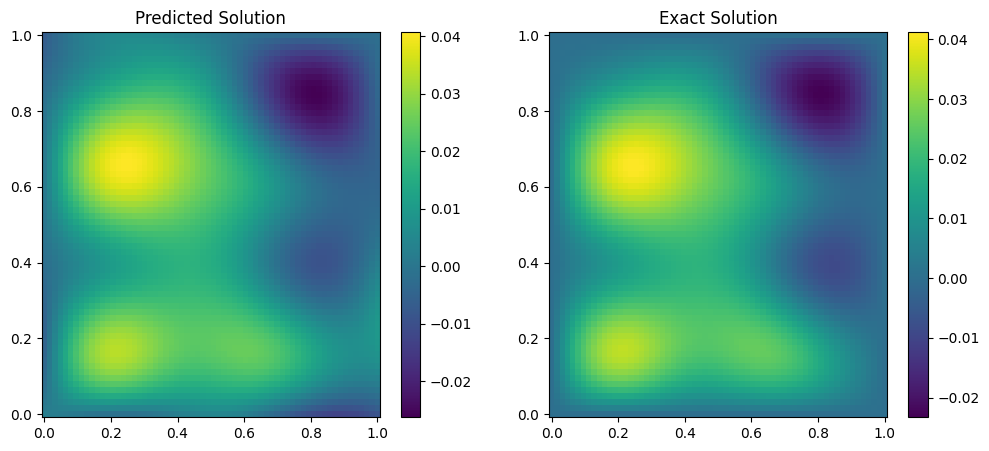

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("Predicted Solution")
plt.pcolormesh(X, Y, U_pred, shading='auto')
plt.colorbar()
plt.subplot(1, 2, 2)
plt.title("Exact Solution")
plt.pcolormesh(X, Y, U_exact, shading='auto')
plt.colorbar()
plt.show()

## Train Data Driven Model

In [10]:
# create training set for data-driven model
training_set = DataLoader(torch.utils.data.TensorDataset(
    torch.tensor(np.stack([X.flatten(), Y.flatten()], axis=1), dtype=torch.float32, device=pinn.device),
    torch.tensor(sol.flatten()*1000, dtype=torch.float32, device=pinn.device)
), batch_size=1024, shuffle=True)

In [12]:
# Train data-driven model
n_epochs_data_driven = 2000
n_epochs_fine_data_driven = 100

optimizer_ADAM_data_driven = optim.Adam(data_driven_model.parameters(), lr=0.01)
optimizer_LBFGS_data_driven = optim.LBFGS(data_driven_model.parameters(),
                              lr=float(0.5),
                              max_iter=50,
                              max_eval=5000,
                              history_size=150,
                              line_search_fn="strong_wolfe",
                              tolerance_change=1.0 * np.finfo(float).eps)


In [13]:
hist_data_driven = data_driven_model.fit(training_set, 
                                         num_epochs=n_epochs_data_driven, 
                                         optimizer=optimizer_ADAM_data_driven)
hist_fine_data_driven = data_driven_model.fit(training_set, 
                                              num_epochs=n_epochs_fine_data_driven, 
                                              optimizer=optimizer_LBFGS_data_driven)

################################  0  ################################
Epoch 0, Loss: 2.109850e+02
################################  1  ################################
################################  2  ################################
################################  3  ################################
################################  4  ################################
################################  5  ################################
################################  6  ################################
################################  7  ################################
################################  8  ################################
################################  9  ################################
################################  10  ################################
################################  11  ################################
################################  12  ################################
################################  13  #####################

In [14]:
hist = hist_pre + hist_fine
plt.figure(dpi=150)
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1, len(hist) + 1), hist, label="Train Loss")
plt.xscale("log")
plt.legend()

NameError: name 'hist_pre' is not defined

In [15]:
x = np.linspace(0, 1, N)
y = np.linspace(0, 1, N)
X, Y = np.meshgrid(x, y, indexing='ij')
U_pred = data_driven_model(torch.tensor(np.stack([X.flatten(), Y.flatten()], axis=1), dtype=torch.float32, device=pinn.device)).detach().cpu().numpy().reshape(N, N)
U_pred = U_pred / 1000.0  # rescale back
U_exact = data_generator.exact_solution(X, Y)

err = (torch.mean((torch.tensor(U_pred) - torch.tensor(U_exact)) ** 2) / torch.mean(torch.tensor(U_exact) ** 2)) ** 0.5 * 100
print("L2 Relative Error Norm: ", err.item(), "%")

L2 Relative Error Norm:  70.25522392245526 %


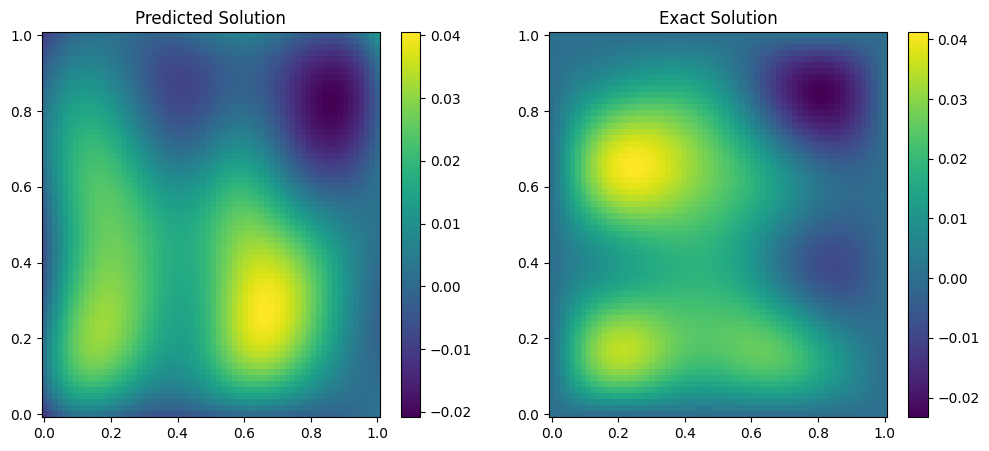

In [106]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("Predicted Solution")
plt.pcolormesh(X, Y, U_pred, shading='auto')
plt.colorbar()
plt.subplot(1, 2, 2)
plt.title("Exact Solution")
plt.pcolormesh(X, Y, U_exact, shading='auto')
plt.colorbar()
plt.show()